# SYDE 556/750 --- Assignment 3

**Student ID: 00000000**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.


In [4478]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from uuid import uuid4

# Fix the numpy random seed for reproducible results
s = 18945
np.random.seed(s)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [4479]:
def rmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))


def rms(x):
    return np.sqrt(np.mean(np.power(x, 2)))

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).


In [4480]:
tau_ref = 2 / 1000
tau_rc = 20 / 1000


def maxJ(tau_ref=tau_ref, tau_rc=tau_rc, max_rate=200):
    return 1 / (1 - np.exp((tau_ref - 1 / max_rate) / tau_rc))


def gain(j_max=2, e=1, intercept=0):
    return (j_max - 1) / (2 - e * intercept)


def bias(alpha=1, e=1, intercept=0):
    return 1 - alpha * e * intercept


def lif_encode_2d(neuron, xy):
    J = neuron.a * np.vdot(xy, neuron.circ) + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def print_block(title, data):
    print(title + " ----------")
    print(data)
    print("-----------------")


class Population:
    def __init__(self, num_neurons=1, state=None, neuron_overrides=[]):
        self.num_neurons = num_neurons
        self.rates = []
        self.spikes = []
        if state == None:
            self.default_neuron_states = {
                "min_rate": 100,
                "max_rate": 200,
                "encoder": [-1, 1],
                "tau_ref": 2 / 1000,
                "tau_rc": 20 / 1000,
                "min_x_int": -2,
                "max_x_int": 2,
            }

        else:
            self.default_neuron_states = state
        self.neurons = []
        if len(neuron_overrides) == 0:
            for idx in range(self.num_neurons):
                neuron = Neuron(self.default_neuron_states)
                self.neurons.append(neuron)
        else:
            for neuron_override in neuron_overrides:
                print(neuron_override.get_id())
                self.neurons.append(neuron_override)

    """ Cleans out a population """

    def nuke(self):
        self.neurons = []

    def clear_rates(self):
        self.rates = []

    def clear_spikes(self):
        self.spikes = []

    """ Applies a mutator to each neuron in the population """

    def mutate(self, mutator):
        if len(self.neurons) == 0:
            return
        else:
            for neuron in self.neurons:
                mutator(neuron)

    def spike(self, X, dT, cap=None):
        O = []
        for neuron in self.neurons:
            spikes = neuron.spikies(X, dT, cap)
            O.append(spikes)
        return O

    def get_curves(self, input):
        for neuron in self.neurons:
            self.rates.append(neuron.rates(input))
        return self.rates

    def get_neurons(self):
        return self.neurons

    def get_neuron_by_index(self, idx):
        return self.neurons[idx]

    def get_neuron_by_id(self, target_id):
        match = None
        for neuron in self.neurons:
            if target_id == neuron.get_id():
                match = neuron
        return match

    def get_spikes(self):
        spikes = []
        for neuron in self.neurons:
            spikes.append(neuron.get_spiketrend()[:, 1])
        self.spikes = spikes
        return spikes

    def get_voltages(self):
        voltages = []
        for neuron in self.neurons:
            voltages.append(neuron.get_spiketrend()[:, 0])
        self.voltages = voltages
        return voltages

    def get_ordered_encoders(self):
        encoders = []
        for neuron in self.neurons:
            encoders.append(neuron.get_encoder())
        return encoders

    def get_neuron_count(self):
        return len(self.neurons)

    def get_neurons_by_rate(self, rate_range=[20, 50], stim=0):
        target_neurons = []
        for neuron in self.neurons:
            rate = neuron.encode(stim)
            is_less_then_max = rate < rate_range[1]
            is_more_then_min = rate > rate_range[0]
            if is_less_then_max and is_more_then_min:
                target_neurons.append(neuron)
        return target_neurons


class Neuron(Population):
    def __init__(self, state=None, override=None):
        if override == None:
            self.x_int = np.random.uniform(state["min_x_int"], state["max_x_int"])
            self.max_rate = np.random.uniform(state["min_rate"], state["max_rate"])
            self.e = np.random.choice(state["encoder"])
            self.tau_ref = state["tau_ref"]
            self.tau_rc = state["tau_rc"]
            J_max = maxJ(
                tau_ref=self.tau_ref, tau_rc=self.tau_rc, max_rate=self.max_rate
            )
            self.alpha = gain(J_max, self.e, self.x_int)
            self.j_bias = bias(alpha=self.alpha, e=self.e, intercept=self.x_int)
            self.id = uuid4()
            self.spiketrend = []
            self.firing_rates = []
        else:
            self.x_int = override["x_int"]
            self.max_rate = override["max_rate"]
            self.e = override["encoder"]
            self.tau_ref = override["tau_ref"]
            self.tau_rc = override["tau_rc"]
            self.alpha = override["alpha"]
            self.j_bias = override["j_bias"]
            self.id = uuid4()
            self.spiketrend = override["spiketrend"]
            self.firing_rates = override["firing_rates"]

    def whoisthis(self):
        print(self.__dict__)

    def encode(self, x):
        J = self.alpha * x * self.e + self.j_bias
        if J > 1:
            return 1 / (self.tau_ref - self.tau_rc * np.log(1 - 1 / J))
        return 0

    def encodeJ(self, x):
        return self.alpha * x * self.e + self.j_bias

    def voltage(self, J, V, dT):
        return V + (dT * (1 / self.tau_rc) * (J - V))

    def howmanyspikes(self):
        spike_points = self.spiketrend[:, 1]
        num_spikes = int(spike_points.tolist().count(1))
        return num_spikes

    def get_intercept(self):
        return self.x_int

    def get_gain(self):
        return self.alpha

    def get_bias(self):
        return self.j_bias

    def get_max_rate(self):
        return self.max_rate

    def get_tau_rc(self):
        return self.tau_rc

    def get_tau_ref(self):
        return self.tau_ref

    def get_id(self):
        return self.id

    def set_encoder(self, encoder):
        self.e = encoder

    def get_encoder(self):
        return self.e

    def me(self):
        return self

    def dangerously_set_id(self, ied):
        self.id = ied

    def set_rate(self, rate):
        self.max_rate = rate

    def set_bias(self, bias):
        self.j_bias = bias

    def set_gain(self, gain):
        self.alpha = gain

    def get_spiketrend(self):
        return self.spiketrend

    def get_rates(self):
        return self.firing_rates

    def rates(self, x):
        self.firing_rates = []
        for point in x:
            self.firing_rates.append(self.encode(point))
        return self.firing_rates

    def clear_rates(self):
        self.firing_rates = []

    def spikies(self, X, dT, cap=None):
        N = np.floor(self.tau_ref / dT)
        V_th = 1
        V_rest = 0
        spikes = np.array([np.zeros(len(X)), np.zeros(len(X))]).T
        V = V_rest
        V_prev = V_rest
        ref_period = False
        for idx, x in enumerate(X):
            if ref_period == True:
                V = V_rest
                V_prev = V_rest
                # voltage is 0
                spikes[idx][0] = 0
                # no spike so set it to 0
                spikes[idx][1] = 0
                # we have completed one ref cycle
                ref_period = False
            else:
                J = self.encodeJ(x)
                V = self.voltage(J, V_prev, dT)
                if V >= V_th:
                    # we have a spike so assign second column to 1 to indicate a spike
                    spikes[idx][1] = int(1)
                    # start the ref period
                    ref_period = True
                    # assign the first collumn to the current voltage
                    # assign a constant spiking voltage to make identification easier
                    if cap != None:
                        spikes[idx][0] = cap
                    else:
                        spikes[idx][0] = V
                    # reset the voltage to 0
                    V = V_rest
                    V_prev = V_rest
                else:
                    if V < V_rest:
                        V = V_rest
                    # no spikes to assign second column to 0
                    spikes[idx][1] = int(0)
                    # still capture the voltage
                    spikes[idx][0] = V
                    # assign the previous voltage to the current voltage for next iteration
                    V_prev = V
        self.spiketrend = spikes
        return spikes
        """
        num_ref_steps = np.floor(self.tau_ref / dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha * stim * self.e + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1:  # spike
                v = v  # constant spike voltage
                ref_count = num_ref_steps
                spike_count += 1
            elif v < 0:  # keep positive
                v = 0
            if v >= 1:
                spikes.append(1)
            else:
                spikes.append(0)

            v_next = v + dt * (1 / self.tau_rc) * (J - v)
            voltages.append(v)
            v = v_next
        self.spiketrend = voltages
        return spikes
        """

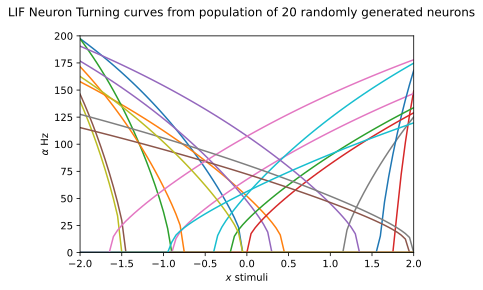

In [4481]:
# we want 20 neurons
num_neurons = 20
# with this default state
state = {
    "min_rate": 100,
    "max_rate": 200,
    "encoder": [-1, 1],
    "tau_ref": 2 / 1000,
    "tau_rc": 20 / 1000,
    "min_x_int": -2,
    "max_x_int": 2,
}

# create a population of 20 neurons with the default states
ensemble1 = Population(
    num_neurons,
    state=state,
)
S = 81  # samples
X = np.linspace(-2, 2, S)
curves = np.array(ensemble1.get_curves(X))

plt.figure()
plt.suptitle(
    "LIF Neuron Turning curves from population of 20 randomly generated neurons"
)
for curve in curves:
    plt.plot(X, curve)
plt.xlabel("$x$ stimuli")
plt.ylabel("$\\alpha$ Hz")
plt.xlim([-2, 2])
plt.ylim([0, 200])
plt.show()

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).


Decoders with noise ----------
[-0.00068122 -0.00101302 -0.00127595  0.0001646  -0.00072472 -0.00063046
  0.0018315   0.0016065  -0.00056462  0.00216541  0.00076354 -0.00112071
  0.00170102  0.00196816 -0.00276315 -0.00117113  0.00196086 -0.00127341
 -0.00057206  0.00146749]
-----------------


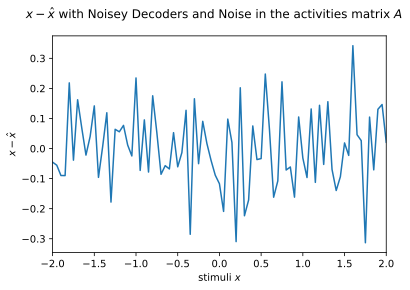

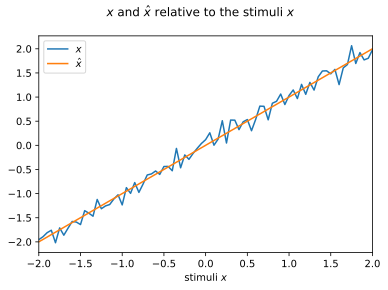

RMSE ----------
0.12919565696552784
-----------------


In [4482]:
A = curves
X = X
noise_stdev = 0.1 * 200
w_noise = np.random.normal(scale=noise_stdev, size=np.shape(A))
A_NOISE = A + w_noise
N = len(X)
n = num_neurons
# find decoders via least squares solution
D = np.linalg.lstsq(
    A @ A.T + 0.5 * N * np.square(noise_stdev) * np.eye(n), A @ X.T, rcond=None
)[0]

print_block("Decoders with noise", D)

X_hat = np.dot(D, A_NOISE)
X = np.array(X)
E = X - X_hat

plt.figure()
plt.suptitle("$x-\hat{x}$ with Noisey Decoders and Noise in the activities matrix $A$")
plt.plot(X, E)
plt.xlabel("stimuli $x$")
plt.ylabel("$x-\hat{x}$")
plt.xlim([-2, 2])
plt.show()

plt.figure()
plt.suptitle("$x$ and $\hat{x}$ relative to the stimuli $x$")
x1 = plt.plot(X, X_hat, label="$x$")
x2 = plt.plot(X, X, label="$\hat{x}$")
plt.xlim([-2, 2])
plt.legend(handles=[x1, x2], labels=[])
plt.xlabel("stimuli $x$")
plt.show()


print_block("RMSE", rmse(X, X_hat))

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$


In [4483]:
def signal_rms(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))


def im_normal_rand():
    return np.random.normal() + np.random.normal() * 1j


def symmetry_exists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)


def locations(index):
    return int(index[0])


def rescale(signal, ideal_rms):
    cur_rms = signal_rms(signal)
    rescaled_signal = [p * ideal_rms / cur_rms for p in signal]
    return rescaled_signal


def zippify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))


def generate_signal(T, dt, rms, limit, seed):
    if seed != 0:
        np.random.seed(int(seed))
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = im_normal_rand()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetry_exists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescale(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = zippify(F, Z)
    return z, Z


def plot_signal(
    signal, domain="time", T=1, dt=1 / 1000, show_rmse=True, bandwidth=False
):
    t = np.arange(0, T, dt)
    if domain == "time":
        plt.figure()
        plt.plot(t, signal["x"])
        if bandwidth:
            plt.suptitle(
                "$x(t)$ signal with " + str(signal["freq"]) + " Hz bandwidth",
            )
        else:
            plt.suptitle(
                "$x(t)$ signal with " + str(signal["freq"]) + " Hz limit",
            )
        plt.xlabel("$t$ sec.")
        plt.ylabel("$x(t)$")
        plt.xlim([0, T])
        plt.show()
        if show_rmse:
            print("time-domain RMSE " + str(np.round(signal_rms(signal["x"]), 3)))
    if domain == "frequency":
        plt.figure()
        plt.plot(t, signal["X"])
        if bandwidth:
            plt.suptitle(
                "$x(\omega)$ signal with " + str(signal["freq"]) + " Hz bandwidth",
            )
        else:
            plt.suptitle(
                "$x(\omega)$ signal with " + str(signal["freq"]) + " Hz limit",
            )
        plt.xlabel("$w$ Hz.")
        plt.ylabel("$x(\omega)$")
        plt.show()
        if show_rmse:
            print("frequency-domain RMSE " + str(np.round(signal_rms(signal["X"]), 3)))


def synaptic_filter(tau=5 / 1000, dt=1 / 1000, ms=1000):
    t_h = np.arange(ms) * dt - 0.5
    h = (1 / tau) * np.exp(-t_h / tau)
    h[np.where(t_h < 0)] = 0
    h = h / np.linalg.norm(h, 1)
    return h, t_h


def filter(x, h, t):
    return np.convolve(x, h, mode="same")[: len(t)]

11fcbe1f-a1fc-4d18-8fbf-35c4e845a4a3
9bb6d868-3760-4218-99c9-22c3b405c245


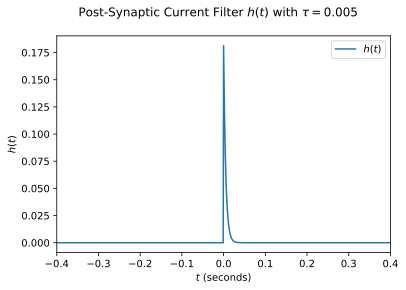

In [4484]:
import copy

neuron_candidates = ensemble1.get_neurons_by_rate(rate_range=[20, 50], stim=0)
candidate = np.random.choice(neuron_candidates)


override = {
    "x_int": candidate.get_intercept(),
    "max_rate": candidate.get_max_rate(),
    "encoder": candidate.get_encoder(),
    "tau_ref": candidate.get_tau_ref(),
    "tau_rc": candidate.get_tau_rc(),
    "alpha": candidate.get_gain(),
    "j_bias": candidate.get_bias(),
    "spiketrend": candidate.get_spiketrend(),
    "firing_rates": candidate.get_rates(),
}


neuron_1 = Neuron(state=None, override=override)
neuron_2 = Neuron(state=None, override=override)


neuron_1.set_encoder(1)
neuron_1.dangerously_set_id(uuid4())
neuron_2.set_encoder(-1)
neuron_1.set_encoder(1)

# create an ensemble wiht our neuron
ensemble2 = Population(state=None, neuron_overrides=[neuron_1, neuron_2])


# generate input signal
T = 1
dt = 1 / 1000
rms = 1
limit = 5
t = np.arange(0, T, dt)
x, X = generate_signal(T, dt, rms, limit, s)

# spike the neurons by giving them an input signal
ensemble2.spike(x, dt)

# generate synapic filter
h, t_h = synaptic_filter(tau=5 / 1000, dt=dt, ms=T * 1000)


plt.figure()
plt.suptitle("Post-Synaptic Current Filter $h(t)$ with $\\tau=0.005$")
plt.xlabel("$t$ (seconds)")
plt.ylabel("$h(t)$")
x1 = plt.plot(t_h, h, label="$h(t)$")
plt.legend(handles=[x1], labels=[])
plt.xlim([-0.4, 0.4])
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.


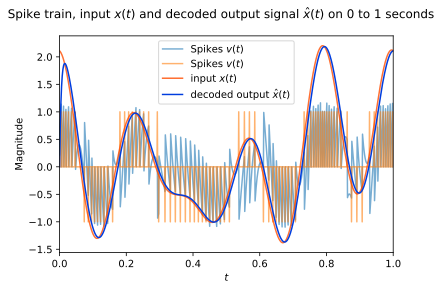

In [4485]:
# from part a)
neuron_pos_encoder = ensemble2.get_neuron_by_index(0)
neuron_neg_encoder = ensemble2.get_neuron_by_index(1)

# make sure we have the correct signed encoder
assert neuron_pos_encoder.get_encoder() == 1
assert neuron_neg_encoder.get_encoder() == -1


# get the first colum of the outputs which is the voltages
v_out_pos = neuron_pos_encoder.get_spiketrend()#[:, 0]
v_out_neg = neuron_neg_encoder.get_spiketrend()#[:, 0]

# checking that they are reflections of themselves
assert np.array(v_out_neg).all() == -1 * np.array(v_out_pos).all()

# align spikes
spikes = np.array([v_out_pos, v_out_neg])
r = spikes[0] - spikes[1]


x_hat = filter(x, h, t)

plt.figure()
plt.suptitle(
    "Spike train, input $x(t)$ and decoded output signal $\hat{x}(t)$ on 0 to 1 seconds"
)
a = plt.plot(t, r, label="Spikes $v(t)$", alpha=0.6)
b = plt.plot(t, x, label="input $x(t)$", alpha=0.8, color="#FF4D00")
c = plt.plot(t, x_hat, label="decoded output $\hat{x}(t)$", color="#003DDE")
plt.xlim([0, 1])
plt.legend(handles=[a, b, c], labels=[])
plt.xlabel("$t$")
plt.ylabel("Magnitude")
plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.


In [4486]:
print_block("RMSE",rmse(x,x_hat))

RMSE ----------
0.1737740187209444
-----------------


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.


RMSE for 8 neurons from spikes ----------
1.375865756122073
-----------------
RMSE for 8 neurons from activities ----------
0.2556622504392272
-----------------
RMSE for 16 neurons from spikes ----------
1.8411883465592354
-----------------
RMSE for 16 neurons from activities ----------
0.16655459817920598
-----------------
RMSE for 32 neurons from spikes ----------
1.8713342921109977
-----------------
RMSE for 32 neurons from activities ----------
0.10514449469879364
-----------------
RMSE for 64 neurons from spikes ----------
0.6888350588291419
-----------------
RMSE for 64 neurons from activities ----------
0.07087349168376288
-----------------
RMSE for 128 neurons from spikes ----------
0.24927442973092223
-----------------
RMSE for 128 neurons from activities ----------
0.04914791260802407
-----------------
RMSE for 256 neurons from spikes ----------
0.11778318037163224
-----------------
RMSE for 256 neurons from activities ----------
0.03514458778002315
-----------------


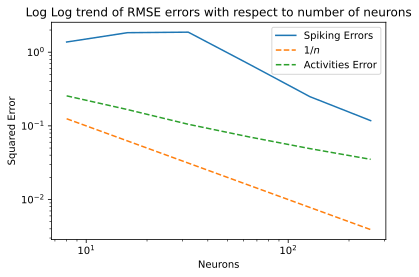

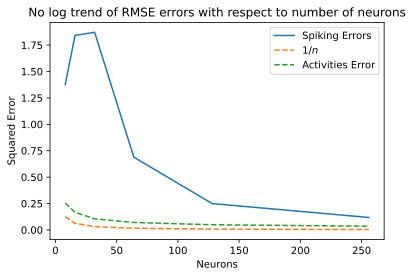

In [4487]:
# create sets of neurons
neuron_sets = [8, 16, 32, 64, 128, 256]
num_sets = 5
# with this default state
state = {
    "min_rate": 100,
    "max_rate": 200,
    "encoder": [-1, 1],
    "tau_ref": 2 / 1000,
    "tau_rc": 20 / 1000,
    "min_x_int": -2,
    "max_x_int": 2,
}

populations = []
# create populations
for amount in neuron_sets:
    set = []
    for count in range(num_sets):
        ensemble = Population(num_neurons=amount, state=state)
        set.append(ensemble)
    populations.append(set)

T = 1
dt = 1 / 1000
rms = 1
limit = 5
t = np.arange(0, T, dt)


# generate synapic filter
h, t_h = synaptic_filter(tau=5 / 1000, dt=dt, ms=T * 1000)

# spike the neurons
population_errors_spike = []
population_errors_activities = []
for population_set in populations:
    set_errors_spike = []
    set_errors_activites = []
    for idx, population in enumerate(population_set):
        x, X = generate_signal(T, dt, rms, limit, s)
        population.spike(x, dt)
        curves = np.array(population.get_curves(x))
        population_spikes = np.array(population.get_spikes())
        ordered_encoders = np.array(population.get_ordered_encoders())
        r = np.zeros(len(t))
        for idx, population_spike in enumerate(population_spikes):
            if ordered_encoders[idx] == 1:
                r = r + population_spike
            if ordered_encoders[idx] == -1:
                r = r - population_spike
            else:
                r = r
        x_hat = filter(r, h, t)
        error_denom_spike = rmse(x, x_hat)
        set_errors_spike.append(1 / error_denom_spike)

        A = curves
        noise_stdev = 0.1 * 200
        w_noise = np.random.normal(scale=noise_stdev, size=np.shape(A))
        A_NOISE = A + w_noise
        N = len(x)
        n = population.get_neuron_count()
        x = np.array(x)
        # find decoders via least squares solution
        D = np.linalg.lstsq(
            A @ A.T + 0.5 * N * np.square(noise_stdev) * np.eye(n), A @ x.T, rcond=None
        )[0]
        x_hat_activities = np.dot(D, A_NOISE)
        x = np.array(x)
        error_activities = rmse(x, x_hat_activities)
        set_errors_activites.append(error_activities)

    mean_error_spikes = np.mean(np.array(set_errors_spike))
    mean_error_activites = np.mean(np.array(set_errors_activites))
    population_errors_spike.append(mean_error_spikes)
    population_errors_activities.append(mean_error_activites)


for idx, errors in enumerate(population_errors_spike):
    print_block("RMSE for " + str(neuron_sets[idx]) + " neurons from spikes", errors)
    print_block(
        "RMSE for " + str(neuron_sets[idx]) + " neurons from activities",
        population_errors_activities[idx],
    )


n = [1 / N for N in neuron_sets]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title("Log Log trend of RMSE errors with respect to number of neurons")
x1 = ax.plot(neuron_sets, population_errors_spike, label="Spiking Errors")
x2 = ax.plot(neuron_sets, n, "--", label="$1/n$")
x3 = ax.plot(neuron_sets, population_errors_activities, "--", label="Activities Error")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(handles=[x1, x2, x3], labels=[])
plt.xlabel("Neurons")
plt.ylabel("Squared Error")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title("No log trend of RMSE errors with respect to number of neurons")
x1 = ax.plot(neuron_sets, population_errors_spike, label="Spiking Errors")
x2 = ax.plot(neuron_sets, n, "--", label="$1/n$")
x3 = ax.plot(neuron_sets, population_errors_activities, "--", label="Activities Error")
ax.legend(handles=[x1, x2, x3], labels=[])
plt.xlabel("Neurons")
plt.ylabel("Squared Error")
plt.show()

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?


As we can see from the above graphs, there is a negative exponentialy decaying relationship beween the number of neurons and the error. As we increase the number of neurions we see a rapid decrease in the error until we reach about 200 neurons in the population at which point we begin to see a decay in the decrease in the error, relative to the increase in the number of neurons. What can be  said is that generally speaking
$$
\begin{equation}
Error \propto \frac{1}{N}, \Rightarrow \text{ as } N \to \infty, Error \to 0
\end{equation}
$$
where $N$ is the integer number of neurons encoding and decoding an input in a population

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.


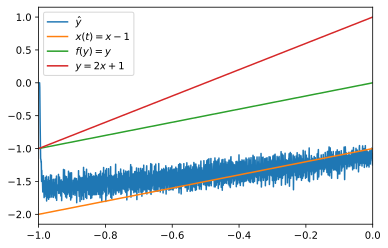

In [4488]:
def decoder(signal=[], A=[], num_neurons=200):
    X = signal
    noise_stdev = 0.1 * 200
    w_noise = np.random.normal(scale=noise_stdev, size=np.shape(A))
    A_NOISE = A + w_noise
    N = len(X)
    n = num_neurons
    # find decoders via least squares solution
    D = np.linalg.lstsq(
        A @ A.T + N * np.square(noise_stdev) * np.eye(n),
        A @ X.T,
        rcond=None,
    )[0].T
    return D, A_NOISE


# we want 200 neurons
num_neurons = 200
# with this default state
state = {
    "min_rate": 100,
    "max_rate": 200,
    "encoder": [-1, 1],
    "tau_ref": 2 / 1000,
    "tau_rc": 20 / 1000,
    "min_x_int": -1,
    "max_x_int": 1,
}

# create a population of 200 neurons with the default states
ensemble_x = Population(num_neurons=200, state=state)
ensemble_y = Population(num_neurons=200, state=state)


T = 1
dt = 1 / 1000
rms = 1
limit = 5
t = np.arange(-1, 1, dt)

h, t_h = synaptic_filter(tau=5 / 1000, dt=dt, ms=T * 1000)


# y(x) = x
x1 = np.linspace(-1, 0, len(t))
# y(x) = 2x+1
x2 = [2 * t + 1 for t in x1]


curves_x = np.array(ensemble_x.get_curves(x2))
curves_y = np.array(ensemble_y.get_curves(x1))

# create matrix of activities
A_X = curves_x
A_Y = curves_y

# generate decoders
D_X, A_X_NOISE = decoder(signal=np.array(x2), A=A_X, num_neurons=num_neurons)
D_Y, A_Y_NOISE = decoder(signal=np.array(x1), A=A_Y, num_neurons=num_neurons)

# make sure we have all our decoders
assert len(D_X) == num_neurons
assert len(D_Y) == num_neurons


# make test input
ls = np.linspace(-1, 0, len(t))
x = [t - 1 for t in ls]

ensemble_x.spike(x, dt)
spike_x = np.array(ensemble_x.get_spikes())

fspikes = []
for spike in spike_x:
    fspike = np.convolve(spike, h, mode="same")
    fspikes.append(fspike)

A = np.array(fspikes)

x_hat = np.dot(D_X, A / dt)

ensemble_y.spike(x_hat, dt)
spike_y = np.array(ensemble_y.get_spikes())

fspikes = []
for spike in spike_y:
    fspike = np.convolve(spike, h, mode="same")
    fspikes.append(fspike)

A = np.array(fspikes)

y_hat = np.dot(D_Y, A / dt)

plt.figure()
a = plt.plot(ls, y_hat, label="$\hat{y}$")
plt.xlim([-1, 0])
b = plt.plot(ls, x, label="$x(t)=x-1$")
c = plt.plot(ls, x1, label="$f(y)=y$")
d = plt.plot(ls, x2, label="$y=2x+1$")
plt.legend(handles=[a, b, c], labels=[])
plt.show()

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)


In [4489]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.


In [4490]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?


✍ \<YOUR SOLUTION HERE\>


# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).


In [4491]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.


In [4492]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$


In [4493]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$


In [4494]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.


✍ \<YOUR SOLUTION HERE\>
